In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

# Preprocessing

In [3]:
path='D:/DataSets/365/TimeSeries/3/index2018.csv'
df_raw=pd.read_csv(path)
df=df_raw.copy()

In [4]:
df.date=pd.to_datetime(df.date,dayfirst=True)
df.set_index('date',inplace=True)

In [5]:
#df.index=pd.to_datetime(df.index,dayfirst=True)

In [6]:
df=df.asfreq('b')
df=df.fillna(method='ffill')

### Removing surplus data

In [7]:
df['market_value']=df.spx

In [8]:
df.columns

Index(['spx', 'dax', 'ftse', 'nikkei', 'market_value'], dtype='object')

In [9]:
del df['spx'], df['dax'],df['ftse'],df['nikkei']

### Split the data

In [10]:
size=int(len(df)*0.8)
df_train=df.iloc[:size]
df_test=df.iloc[size:]

In [11]:
df_train.tail()

,market_value
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [12]:
df_test.head()

,market_value
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


# White Noise

In [13]:
# Generate White Noise data with an array of random values from a normal distribution. We should set the size, the mean and the std as it ouccure in the our df before
# Look at the documentation for np.random.normal
#Now we can merge or add the df and the wn array together

wn=np.random.normal(loc=df.market_value.mean(),
                    scale=df.market_value.std(),
                    size=len(df)
                   )

df['wn']=wn

In [14]:
df.iloc[:size].describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1283.182953
std,292.559287,491.418857
min,438.920000,-895.602837
25%,914.620000,955.183424
50%,1144.650000,1279.818552
75%,1316.280729,1616.718105
max,1570.252238,3010.724853


Text(0.5, 1.0, 'White Noise Time-series')

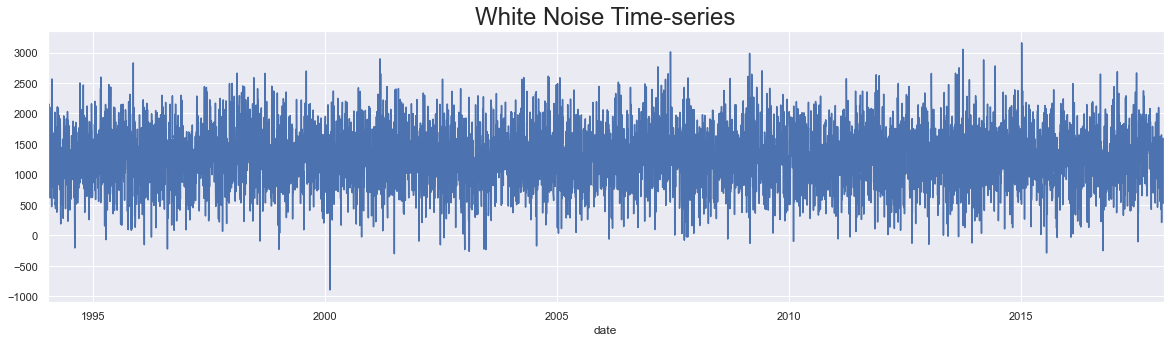

In [15]:
df.wn.plot(figsize=(20,5))
plt.title('White Noise Time-series',size=24)


There is no clear pattern in the white noise<br>
 - same mean
 - same variance
 - NO autocorrelation (doesn´t matter the value before (t-1)

Text(0.5, 1.0, 'S&P closings')

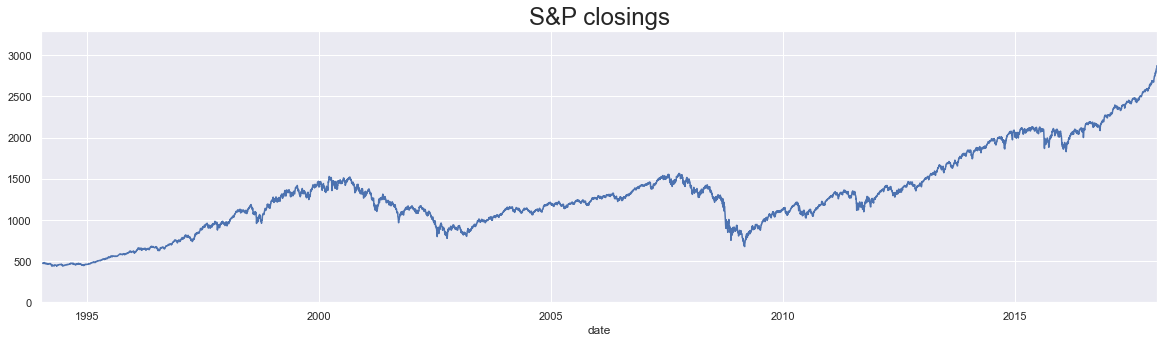

In [16]:
df.market_value.plot(figsize=(20,5))
plt.ylim(0,3300) # To adjust the same scale as in the White Noise

plt.title('S&P closings',size=24)

# RandomWalk

A RandomWalk is a special type of time series where values tend to persist over time and the difference between periods are simpy white noise.<br>
Therefore it is a continued value based on the value before; a White Noise instead, is totally arbitrary

In [17]:
path_rw='D:/DataSets/365/TimeSeries/4/RandWalk.csv'
rw=pd.read_csv(path_rw)
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
rw=rw.asfreq('b')

In [18]:
df['rw']=rw.price #add the randomwalk to our dataframe

Text(0.5, 1.0, 'RandomWalk v S&P')

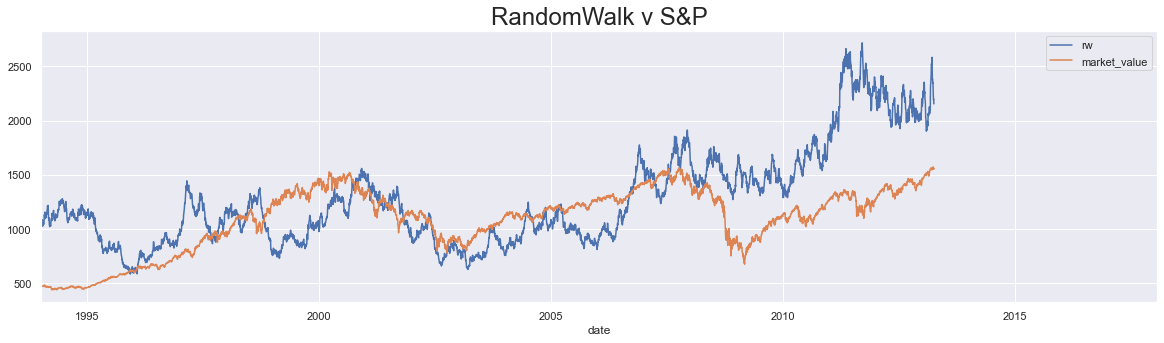

In [19]:
df.rw.plot(figsize=(20,5))
df_train.market_value.plot(figsize=(20,5))
plt.legend()
plt.title('RandomWalk v S&P',size=24)

They looks very similiar, even it is a randomwalk<br>
This also shows the difference between White Noise and Random Walk

# Stationarity

IF the mean, variance and autocorrelation is 0<br>
Therefore, White Noise is stationary

In [20]:
sts.adfuller(df_train.market_value)

(-1.736984745235245,
 0.4121645696770616,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

### Outputs of Dickey-fuller test

line by line

- t-statisic
- p-value
- Used lag
- Number of observations
- critical values 1%, 5%,10%
- Maximum information criterion if autolag is not None (the lower, the easier to make prediction for the future)

Ho: the series is not stationary, it presents heterocedasticity. In another words, your residue depends on itself (i.e.: yt depends on yt-1, yt-1 depends on yt-2 ..., and so on)<br>

Ha: the series is stationary (That is normally what we desire in regression analysis). Nothing more is needed to be done.

In [21]:
sts.adfuller(df['wn'])

(-78.03639694643931,
 0.0,
 0,
 6276,
 {'1%': -3.4313923799633836,
  '5%': -2.862000639842268,
  '10%': -2.567015195598801},
 95127.1391362032)

In [22]:
# There are nans in rw, because it only contains data in the size of the train set.
print(df['rw'].isna().sum())
print(df['rw'].iloc[:size].isna().sum())

1256
0


In [23]:
sts.adfuller(df['rw'].iloc[:size])

(-1.328607392768972,
 0.6159849181617384,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

Rather with rw, White Noise or market_vale we can classified it as stationary data, because the t-statistic is bigger than the critical value. Additional, the p value enforce this result<br>

Therefore the data is non-stationary

H0: data is non-stationary ;  H1: the data is stationary


# Seasonality

We can split the data into three different types:

- Trend  --> Pattern
- Seasonal --> Cyclical effects
- Residual --> error of prediction; Difference between the actual data and the model we fit

### Ways of decompose
- Additive <br>
observed= trend+seasonal+residual

- Multiplication <br>
observed= trend * seasonal * residual

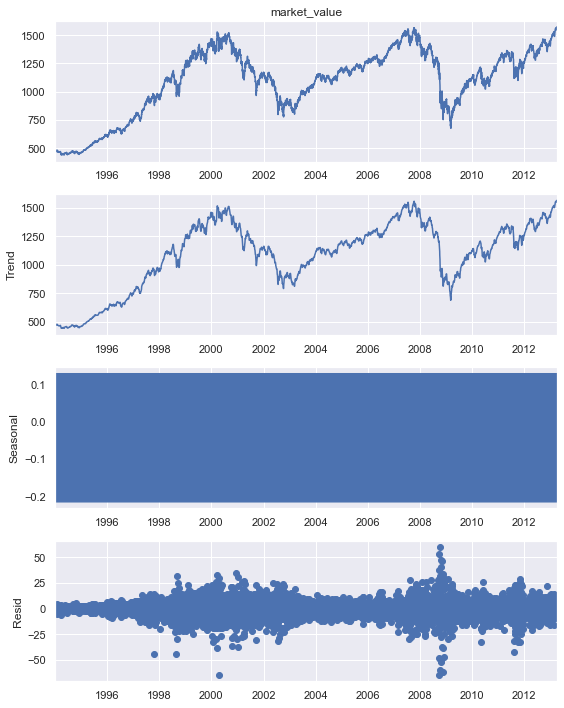

In [24]:
s_dec_additive=seasonal_decompose(df.market_value.iloc[:size],model='additive')
plt.rc("figure", figsize=(8,10))
s_dec_additive.plot()
plt.show()
#Without the plt.show() it is getting plotted twice                          

### Interpretation

- The trend is almost equal to the observation. This is because it uses the precious values as a trend setter
- The seasonal shows no concrete cyclical pattern
- The residuals are higher around 2000 and 2008; this may be due to the dot-bubble and lehman/housing-price bubble



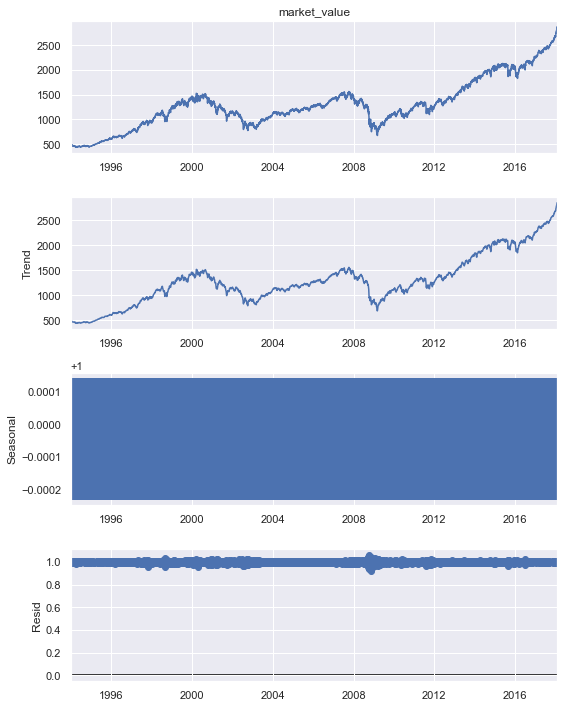

In [25]:
s_dec_multiplicative=seasonal_decompose(df.market_value,model='multiplicative')
plt.rc("figure", figsize=(8,10)) #To figure out if are some errors due to the scale
s_dec_multiplicative.plot()
plt.show()

### Interpretation

- The trend is the same like in additive
- The seasonal looks also quite similiar
- the residuals shows an error in plotting, still no idea why it happend

### Result
We have no seasonality on S&P

### Additive vs. Multiplicative

We use a multiplicative model, if the magnitude in the seasonal pattern depends on the magnitud in the data. If not, we use additive model.<br>
Examples:

- Saleprice for wood, does not depent on the sold volumn
- Amount of passangers depents on the magnitud of the data. Later in time, there where more passangers than earlier

# Correlation between past and Present Values

### Autocorrelation <br>
The correlation between a sequence and itself<br>
A lag is a sample of time <br>
<href> https://math.stackexchange.com/questions/2548314/what-is-lag-in-a-time-series </href>

# ACF

Autocorrelation-function shows the relation between past values and the current one

Text(0.5, 1.0, 'ACF S&P')

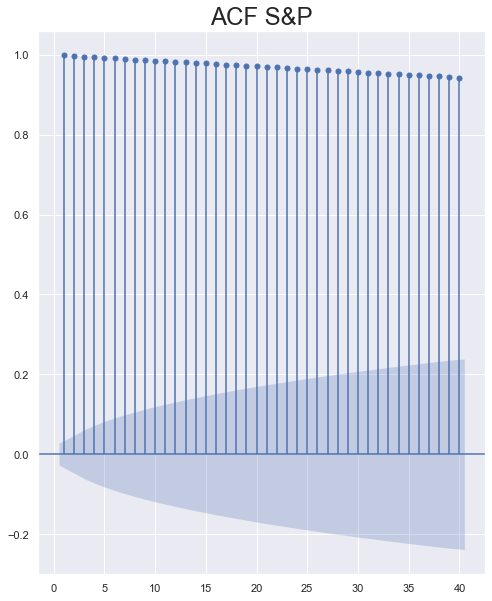

In [26]:
sgt.plot_acf(df.market_value.iloc[:size],lags=40,zero=False)
plt.title('ACF S&P',size=24)

# Interpretation <br>
- X-axis represents the lags <br>
- y-axis indicates the possible values for the autocorrelation koefficient (-1,1)<br>
- respresents the autocorrelation between the time series and itself a x-lags ago (x=5 --> 5 time periods ago)
- The blue area around x axis represent the significance --> as it gets greater in time, the more unlikly it is that this autocorrelation persists. You can see the 0 as a 0 significance and a 0.1 as 10%

### For comparrison with the white noise

Text(0.5, 1.0, 'ACF wn')

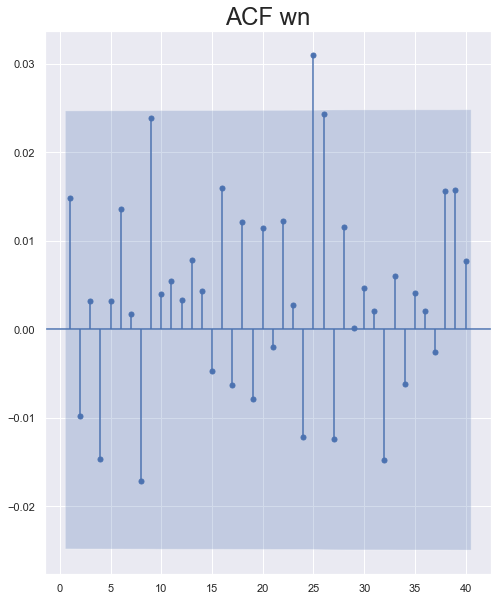

In [28]:
sgt.plot_acf(df.wn,lags=40,zero=False)
plt.title('ACF wn',size=24)

### Interpretation
- The autocorrelation on y-axis is very low (-0.02 and +0.02)
- The points are almost inside the blue area of significance, therefore, there is no autocorrelation
- The 0 Autocorrelation is one of the assumption for the White Noise

Text(0.5, 1.0, 'ACF & RandomWalk')

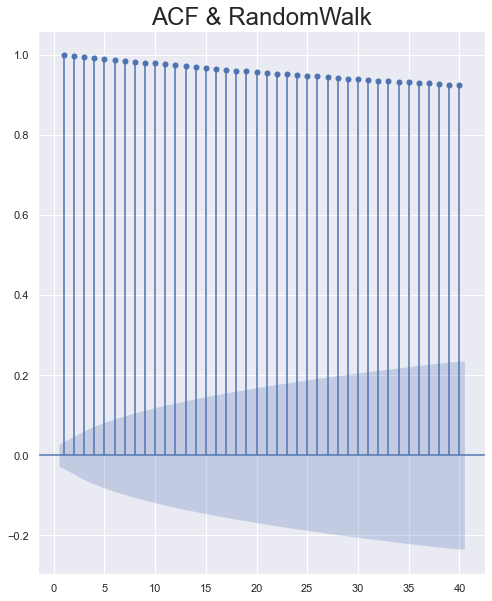

In [34]:
sgt.plot_acf(df.rw.iloc[:size],lags=40,zero=False)
plt.title('ACF & RandomWalk',size=24)

# PACF

The values are affecting directly and indirectly. If we want to know the <b>indirect</b> way of affecting the current value of T-3 we make the following:<br>

T-3 is affecting t-2.<br>
t-2 is affecting t-1.<br>
And t-1 is now affecting t0 <br>

Therefore, t-3 is affecting indirectly to t0.<br>

If we want to compute the how T-3 is affecting <b>directly</b> T0 we will use the <b>P</b>artial <b>A</b>uto<b>c</b>orrelation <b>F</b>unction<br>

The ACF measures the accumulated effects past lags have on the current value, while the PACF measures the direct effects

Text(0.5, 1.0, 'PACF & S&P')

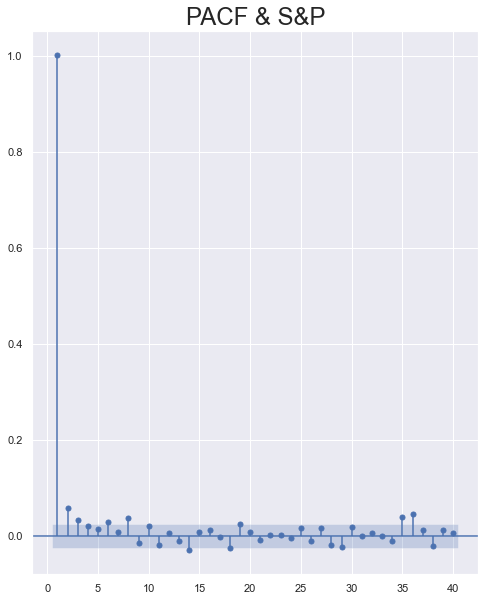

In [36]:
sgt.plot_pacf(df.market_value,lags=40,zero=False, method='ols') #lags=40 is the normal way in Time Series data
plt.title("PACF & S&P",size=24)

### Interpretation
- ACF & PACF from the first lag should be identical, as seen above


Text(0.5, 1.0, 'PACF & WN')

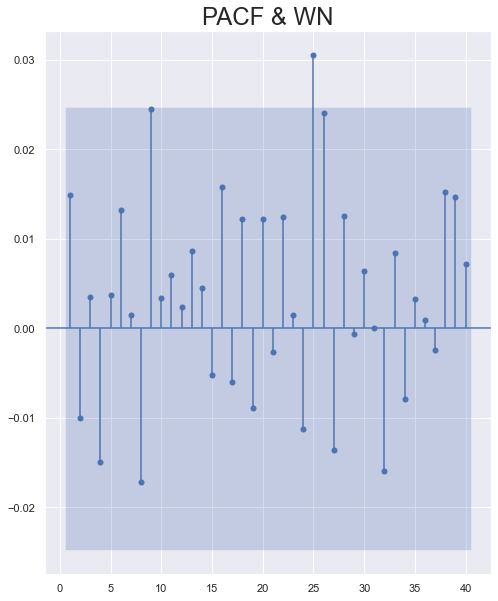

In [38]:
sgt.plot_pacf(df.wn,lags=40,zero=False, method='ols') #lags=40 is the normal way in Time Series data
plt.title("PACF & WN",size=24)

- Completly random --> No autocorrelation